# Class Activation Map 만들기 (활성화 함수)
- Classification model로부터 CAM을 얻어낼 수 있습니다
- CAM으로 물체의 위치를 찾을 수 있습니다
- CAM을 시각화 및 비교할 수 있습니다

## 1. CAM, Grad-CAM용 모델 준비하기, 데이터셋 준비하기
- **CAM(class activation map)**은 특성을 추출하는 CNN 네트워크 뒤에 GAP와 소프트맥스 레이어가 붙는 형태로 구성되어야 한다는 제약이 있다
    - CAM은 <클래스에 대한 활성화 정도를 나타낸 지도>이다  
    
    
- **Grad-CAM**은 이러한 제약이 없다  


- CAM을 위한 모델을 먼저 구성해 기본적인 CAM을 추출한다
- 이 모델에서 Grad-CAM을 활용해 다시 시각화 결과물을 추출한다
- Grad-CAM은 모델의 구조에 제약이 없기 때문에 CAM에만 모델을 맞춰도 충분하다

In [1]:
# 라이브러리 불러오기
# TensorFlow and tf.keras
import tensorflow as tf
from tensorflow import keras

# Helper libraries
import numpy as np
import matplotlib.pyplot as plt

import tensorflow_datasets as tfds

import copy
import cv2
from PIL import Image

print('완료')

완료


In [2]:
# gpu 확인하기
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [3]:
# 데이터 불러오기
# 최초 수행시에는 다운로드가 진행됩니다. 오래 걸릴 수 있으니 유의해 주세요.  
(ds_train, ds_test), ds_info = tfds.load(
    'stanford_dogs',
    split=['train', 'test'],
    shuffle_files=True,
    with_info=True,
)
print('완료')

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Generating splits...:   0%|          | 0/2 [00:00<?, ? splits/s]

Generating train examples...:   0%|          | 0/12000 [00:00<?, ? examples/s]

Shuffling stanford_dogs-train.tfrecord...:   0%|          | 0/12000 [00:00<?, ? examples/s]

Generating test examples...:   0%|          | 0/8580 [00:00<?, ? examples/s]

Shuffling stanford_dogs-test.tfrecord...:   0%|          | 0/8580 [00:00<?, ? examples/s]

Dataset stanford_dogs downloaded and prepared to /aiffel/tensorflow_datasets/stanford_dogs/0.2.0. Subsequent calls will reuse this data.
완료


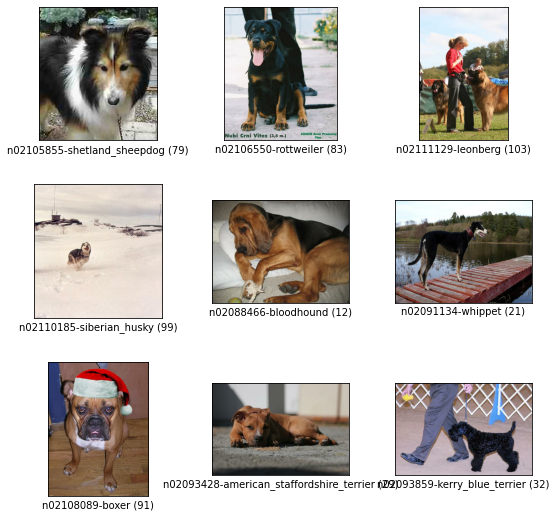

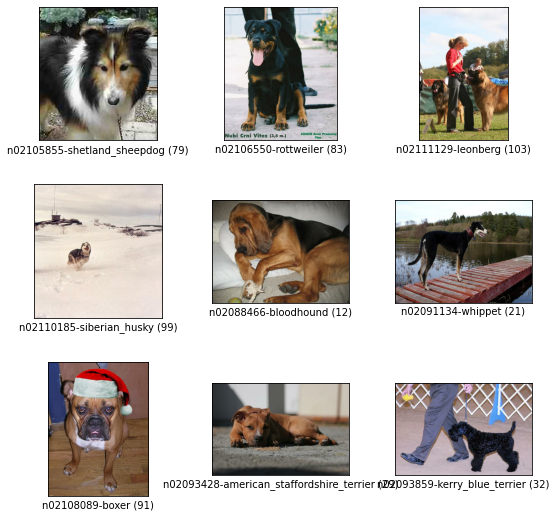

In [4]:
# tfds.show_exaples()를 통해서 각 이미지의 클래스와 그 인덱스(index)를 확인할 수 있다
# 학습 데이터 확인하기
tfds.show_examples(ds_train, ds_info)

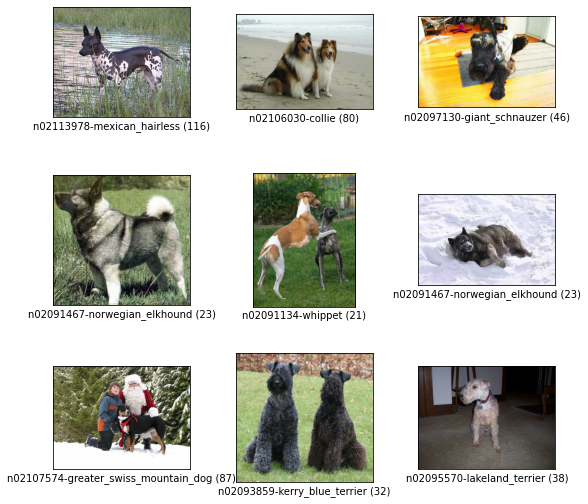

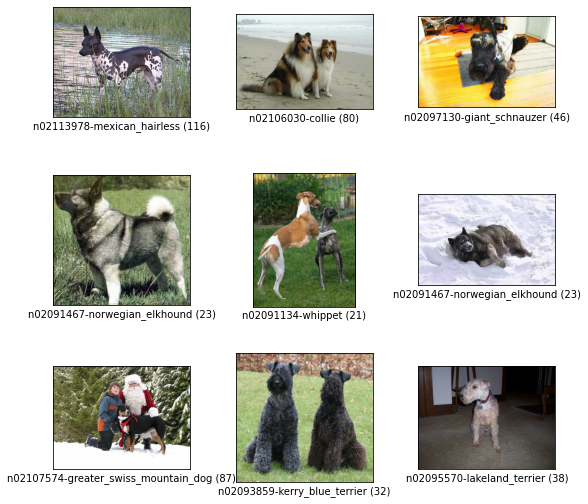

In [5]:
# 테스트 데이터 확인하기
tfds.show_examples(ds_test, ds_info)

## 2. CAM, Grad-CAM용 모델 준비하기, 물체의 위치정보
- 원본 이미지 위에 물체의 위치정보는 어떻게 시각화하기

In [6]:
# 데이터셋의 메타 정보인 df_info를 조회해 features가 어떻게 구성되어 있는지 확인하기
ds_info.features

FeaturesDict({
    'image': Image(shape=(None, None, 3), dtype=tf.uint8),
    'image/filename': Text(shape=(), dtype=tf.string),
    'label': ClassLabel(shape=(), dtype=tf.int64, num_classes=120),
    'objects': Sequence({
        'bbox': BBoxFeature(shape=(4,), dtype=tf.float32),
    }),
})

- image와 label은 입력 이미지와 이미지에 해당하는 정답 클래스 인덱스이다
- bbox는 바운딩 박스로 물체의 위치를 사각형 영역으로 표기하는 방법이다
- BBoxFeature이라는 타입으로 정의되어 있다

### 바운딩 박스를 표시하는 방법들
- 바운딩 박스를 라벨링하는 방법 중 주로 사용되는 방법은 **xywh** 또는 **minmax**이 있다
- **xywh** : 바운딩 박스 중심점을 x, y로 표기하고 사각형의 너비 w와 높이 h를 표기하는 방법이다
    - ex. (x_center, y_center, width, height)
    - x, y가 중심점이 아니라 좌측 상단의 점을 가리킬 수도 있다


- **minmax** : 바운딩 박스를 이루는 좌표의 최소값과 최대값을 통해 표기하는 방법이다
    - ex. (x_min, x_max, y_min, y_max)
    - 좌표의 절대값이 아니라 전체 이미지의 너비와 높이를 기준으로 normalize한 상대적인 값을 표기하는 것이 일반적이다

## 3. CAM, Grad-CAM용 모델 준비하기, CAM을 위한 모델 만들기

In [7]:
# 데이터셋의 클래스 수를 저장
num_classes = ds_info.features["label"].num_classes

# ResNet50 모델을 사전 학습된 가중치와 함께 로드
base_model = keras.applications.resnet50.ResNet50(
    include_top=False,    # Imagenet 분류기의 최상위 fully connected layer를 제거
    weights='imagenet',   # 사전 학습된 ImageNet 가중치를 사용
    input_shape=(224, 224, 3),  # 입력 이미지의 크기 (224x224 RGB 이미지)
    pooling='avg'         # Global Average Pooling(GAP) 레이어를 자동으로 추가
)

# ResNet50의 출력 텐서를 변수 `x`에 저장
x = base_model.output

# 최종 Dense 레이어 추가: 클래스 개수에 맞춰 softmax 활성화 함수를 사용
# 이 레이어는 각 클래스에 대한 확률 분포를 출력
preds = keras.layers.Dense(num_classes, activation='softmax')(x)

# ResNet50 기반으로 CAM 모델 생성
# 입력: ResNet50의 입력, 출력: Dense 레이어의 출력
cam_model = keras.Model(inputs=base_model.input, outputs=preds)

- CAM 모델은 마지막에 fully connected layer 대신 GAP를 사용해야 한다
- 위 코드에서는  ResNet50의 매개변수 pooling에 'avg'를 매개변수로 전달함으로써 쉽게 GAP 연산을 붙일 수 있다

In [8]:
# cam 모델 확인하기
cam_model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 112, 112, 64) 256         conv1_conv[0][0]                 
______________________________________________________________________________________________

## 4. CAM, Grad-CAM용 모델 준비하기, CAM 모델 학습하기
- 학습 데이터와 검증 데이터에 normalizing과 resizing을 포함한 간단한 전처리를 normalize_and_resize_img()에서 수행한다
- 이를 포함하여 apply_normalize_on_dataset()에서 배치를 구성한다  


- input에 이전과 다르게 bbox 정보가 포함되어있지만 지금 수행해야 할 CAM 모델의 학습에는 필요가 없으므로 normalize_and_resize_img 과정에서 제외하였다
- CAM 모델은 object detection이나 segmentation에도 활용될 수 있지만, bounding box 같은 직접적인 라벨을 사용하지 않고 weakly supervised learning을 통해 물체 영역을 간접적으로 학습시키는 방식이기 때문이다

In [9]:
def normalize_and_resize_img(input):
    # 이미지 데이터 정규화 및 크기 조정
    # 'uint8' 데이터를 'float32'로 변환하고 크기를 224x224로 조정
    image = tf.image.resize(input['image'], [224, 224])  # 이미지를 224x224 크기로 조정
    input['image'] = tf.cast(image, tf.float32) / 255.0  # uint8(0~255) 데이터를 float32(0~1)로 정규화
    return input['image'], input['label']  # 정규화된 이미지와 레이블을 반환

def apply_normalize_on_dataset(ds, is_test=False, batch_size=16):
    # 데이터셋에 정규화 및 배치 처리 적용
    ds = ds.map(
        normalize_and_resize_img,  # 데이터셋의 각 이미지를 정규화 및 크기 조정
        num_parallel_calls=2       # 병렬로 데이터를 2개의 코어에서 처리
    )
    ds = ds.batch(batch_size)      # 지정된 크기만큼 배치로 묶음
    
    '''
    # 테스트 데이터가 아닌 경우 데이터 반복 및 셔플링
    if not is_test:
        ds = ds.repeat()           # 데이터셋을 무한 반복 (모델 학습 시 사용)
        ds = ds.shuffle(200)       # 200개의 버퍼 크기로 데이터 셔플링
    '''
    
    ds = ds.prefetch(tf.data.experimental.AUTOTUNE)  # 데이터 로드와 학습을 병렬 처리하여 성능 최적화
    return ds  # 처리된 데이터셋 반환

print('완료')

완료


In [10]:
# 데이터셋에 전처리와 배치처리를 적용합니다.
ds_train_norm = apply_normalize_on_dataset(ds_train)
ds_val_norm = apply_normalize_on_dataset(ds_test)

# 구성된 배치의 모양을 확인해 봅니다. 
for input in ds_train_norm.take(1):
    image, label = input
    print(image.shape)
    print(label.shape)

(16, 224, 224, 3)
(16,)


In [11]:
# 학습하기
cam_model.compile(
    loss='sparse_categorical_crossentropy',
    optimizer=tf.keras.optimizers.SGD(learning_rate=0.01),
    metrics=['accuracy'],
)

print('완료')

완료


In [12]:
history_cam_model = cam_model.fit(
    ds_train_norm,
    steps_per_epoch=int(ds_info.splits['train'].num_examples/16),
    validation_steps=int(ds_info.splits['test'].num_examples/16),
    epochs=2,
    validation_data=ds_val_norm,
    verbose=1,
    use_multiprocessing=True,
)

Epoch 1/2
750/750 [==============================] - 374s 438ms/step - loss: 2.2505 - accuracy: 0.4359 - val_loss: 3.1457 - val_accuracy: 0.2311
Epoch 2/2
750/750 [==============================] - 327s 436ms/step - loss: 0.6862 - accuracy: 0.8138 - val_loss: 1.1734 - val_accuracy: 0.6549


In [13]:
# Q. '/aiffel/class_activation_map' 에 'cam_model1.h5'을 저장하세요.
import os

cam_model_path = os.path.join('/aiffel/class_activation_map', 'cam_model1.h5')
# 모델 저장
cam_model.save(cam_model_path)

print(f"모델이 저장되었습니다: {cam_model_path}")

/opt/conda/lib/python3.9/site-packages/keras/utils/generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


모델이 저장되었습니다: /aiffel/class_activation_map/cam_model1.h5


## 5. CAM

In [14]:
# 커널 재시작 이후 실습을 위해, 이전 스텝의 코드를 모아서 한꺼번에 실행합니다.
import tensorflow as tf
from tensorflow import keras
import numpy as np
import matplotlib.pyplot as plt
import tensorflow_datasets as tfds
import copy
import cv2
from PIL import Image

(ds_train, ds_test), ds_info = tfds.load(
    'stanford_dogs',
    split=['train', 'test'],
    shuffle_files=True,
    with_info=True,
)

def normalize_and_resize_img(input):
    # Normalizes images: `uint8` -> `float32`
    image = tf.image.resize(input['image'], [224, 224])
    input['image'] = tf.cast(image, tf.float32) / 255.
    return input['image'], input['label']

def apply_normalize_on_dataset(ds, is_test=False, batch_size=16):
    ds = ds.map(
        normalize_and_resize_img, 
        num_parallel_calls=2
    )
    ds = ds.batch(batch_size)
    '''
    if not is_test:
        ds = ds.repeat()
        ds = ds.shuffle(200)
    '''
    ds = ds.prefetch(tf.data.experimental.AUTOTUNE)
    return ds

print('완료')

완료


- CAM 생성 작업은 데이터셋 배치 단위가 아니라 개별 이미지 데이터 단위로 이루어지기 때문에 get_one() 함수로 데이터셋에서 한 장씩 뽑을 수 이도록 하였다

In [15]:
def get_one(ds):
    ds = ds.take(1)
    sample_data = list(ds.as_numpy_iterator())
    bbox = sample_data[0]['objects']['bbox']
    image = sample_data[0]['image']
    label = sample_data[0]['label']
    return sample_data[0]

print('완료')

완료


84


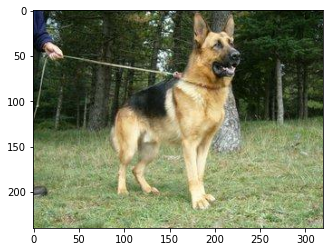

In [16]:
item = get_one(ds_test)
print(item['label'])
plt.imshow(item['image'])
plt.show()

In [17]:
# CAM 생성을 위해 미리 준비된 학습한 모델 불러오기
import os
cam_model_path = os.getenv('HOME')+'/aiffel/class_activation_map/cam_model.h5'
cam_model = tf.keras.models.load_model(cam_model_path)
print('완료')

완료


- CAM을 생성하기 위해서는 (1) 특성 맵, (2) 클래스별 확률을 얻기 위한 소프트맥스 레이어의 가중치, (3) 원하는 클래스의 출력값이 필요한다
- 또 이미지에서 모델이 어떤 부분을 보는지 직관적으로 확인하려면 네트워크에서 나온 CAM을 입력 이미지 사이즈와 같게 만들어 함께 시각화해야한다
- 이를 고려해서 model과 item을 받았을 때 입력 이미지와 동일한 크기의 CAM을 반환한느 함수를 만들어야 한다

In [18]:
def generate_cam(model, item):
    item = copy.deepcopy(item)
    width = item['image'].shape[1]
    height = item['image'].shape[0]
    
    img_tensor, class_idx = normalize_and_resize_img(item)
    
    # 학습한 모델에서 원하는 Layer의 output을 얻기 위해서 모델의 input과 output을 새롭게 정의해줍니다.
    cam_model = tf.keras.models.Model([model.inputs], [model.layers[-3].output, model.output])
    conv_outputs, predictions = cam_model(tf.expand_dims(img_tensor, 0))
    conv_outputs = conv_outputs[0, :, :, :]
    
    # 모델의 weight activation은 마지막 layer에 있습니다.
    class_weights = model.layers[-1].get_weights()[0] 
    
    cam_image = np.zeros(dtype=np.float32, shape=conv_outputs.shape[0:2])
    for i, w in enumerate(class_weights[:, class_idx]):
        # conv_outputs의 i번째 채널과 i번째 weight를 곱해서 누적하면 활성화된 정도가 나타날 겁니다.
        cam_image += w * conv_outputs[:, :, i]

    cam_image /= np.max(cam_image) # activation score를 normalize합니다.
    cam_image = cam_image.numpy()
    cam_image = cv2.resize(cam_image, (width, height)) # 원래 이미지의 크기로 resize합니다.
    return cam_image

print('완료')

완료


- 위에서 작성한 함수를 실행하면 아래와 같은 CAM을 얻을 수 있다

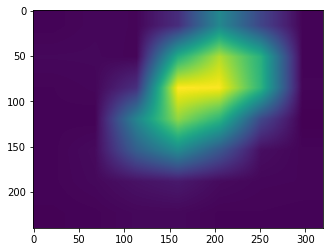

In [19]:
cam_image = generate_cam(cam_model, item)
plt.imshow(cam_image)
plt.show()

In [20]:
# 그려진 CAM 이미지를 원본 이미지와 합지기
def visualize_cam_on_image(src1, src2, alpha=0.5):
    beta = (1.0 - alpha)
    merged_image = cv2.addWeighted(src1, alpha, src2, beta, 0.0)
    return merged_image

print('완료')

완료


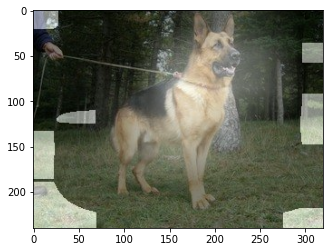

In [21]:
origin_image = item['image'].astype(np.uint8)
cam_image_3channel = np.stack([cam_image*255]*3, axis=-1).astype(np.uint8)

blended_image = visualize_cam_on_image(cam_image_3channel, origin_image)
plt.imshow(blended_image)
plt.show()

## 6. Grad-CAM
- 적용 모델을 유연하게 선택할 수 있는 Grad-CAM의 특성 상 위에서 만들었던 모델을 다시 활용해도 괜찮기 때문에 관찰 대상 모델은 cam_model을 그대로 활용한다

71


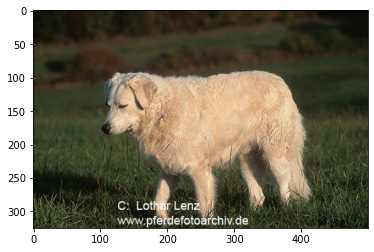

In [22]:
# 새로운 이미지 뽑기
item = get_one(ds_test)
print(item['label'])
plt.imshow(item['image'])
plt.show()

- grad-cam은 관찰을 원하는 레이어와 정답 클래스에 대한 예측값 사이의 그래디언트를 구하고 여기에 GAP 연산을 적용함으로써 관찰 대상이 되는 레이어의 채널별 가중치를 구한다
- Grad-CAM은 어떤 레이어든 CAM 이미지를 뽑아낼 수 있으므로, 그래디언트 계산을 원하는 관찰 대상 레이어 activation_layer를 뽑아서 쓸 수 있도록 activation_layer의 이름을 받고 이를 활용해야 한다

In [23]:
def generate_grad_cam(model, activation_layer, item):
    item = copy.deepcopy(item)
    width = item['image'].shape[1]
    height = item['image'].shape[0]
    img_tensor, class_idx = normalize_and_resize_img(item)
    
    # Grad cam에서도 cam과 같이 특정 레이어의 output을 필요로 하므로 모델의 input과 output을 새롭게 정의합니다.
    # 이때 원하는 레이어가 다를 수 있으니 해당 레이어의 이름으로 찾은 후 output으로 추가합니다.
    grad_model = tf.keras.models.Model([model.inputs], [model.get_layer(activation_layer).output, model.output])
    
    # Gradient를 얻기 위해 tape를 사용합니다.
    with tf.GradientTape() as tape:
        conv_output, pred = grad_model(tf.expand_dims(img_tensor, 0))
    
        loss = pred[:, class_idx] # 원하는 class(여기서는 정답으로 활용) 예측값을 얻습니다.
        output = conv_output[0] # 원하는 layer의 output을 얻습니다.
        grad_val = tape.gradient(loss, conv_output)[0] # 예측값에 따른 Layer의 gradient를 얻습니다.

    weights = np.mean(grad_val, axis=(0, 1)) # gradient의 GAP으로 weight를 구합니다.
    grad_cam_image = np.zeros(dtype=np.float32, shape=conv_output.shape[0:2])
    for k, w in enumerate(weights):
        # output의 k번째 채널과 k번째 weight를 곱하고 누적해서 class activation map을 얻습니다.
        grad_cam_image += w * output[:, :, k]
        
    grad_cam_image = tf.math.maximum(0, grad_cam_image)
    grad_cam_image /= np.max(grad_cam_image)
    grad_cam_image = grad_cam_image.numpy()
    grad_cam_image = cv2.resize(grad_cam_image, (width, height))
    return grad_cam_image

print('완료')

완료


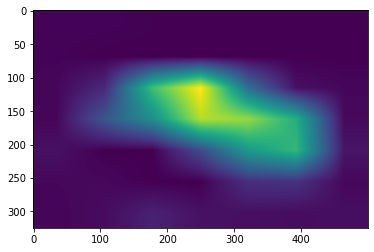

In [24]:
grad_cam_image = generate_grad_cam(cam_model, 'conv5_block3_out', item)
plt.imshow(grad_cam_image)
plt.show()

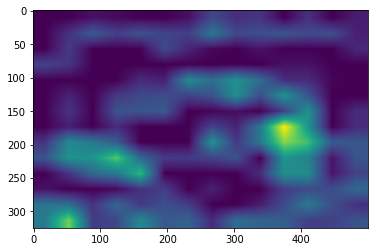

In [25]:
grad_cam_image = generate_grad_cam(cam_model, 'conv4_block3_out', item)
plt.imshow(grad_cam_image)
plt.show()

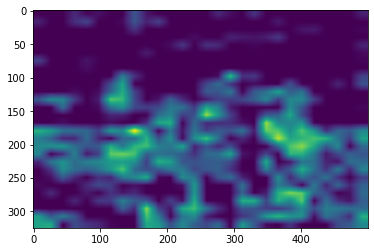

In [26]:
grad_cam_image = generate_grad_cam(cam_model, 'conv3_block3_out', item)
plt.imshow(grad_cam_image)
plt.show()

## 7. Detection with CAM
- CAM에서 물체의 위치를 찾는 detection을 해보자

67


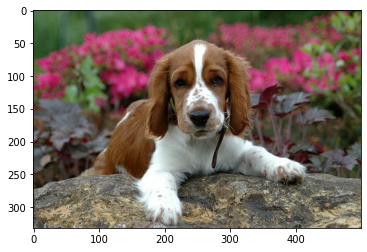

In [27]:
# 새로운 이미지 뽑기
item = get_one(ds_test)
print(item['label'])
plt.imshow(item['image'])
plt.show()

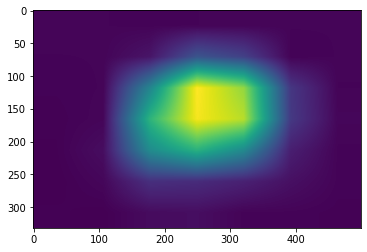

In [28]:
cam_image = generate_cam(cam_model, item)
plt.imshow(cam_image)
plt.show()

In [29]:
def get_bbox(cam_image, score_thresh=0.05):
    low_indicies = cam_image <= score_thresh
    cam_image[low_indicies] = 0
    cam_image = (cam_image*255).astype(np.uint8)
    
    contours,_ = cv2.findContours(cam_image, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    cnt = contours[0]
    rotated_rect = cv2.minAreaRect(cnt)
    rect = cv2.boxPoints(rotated_rect)
    rect = np.int0(rect)
    return rect

print('완료')

완료


In [30]:
rect = get_bbox(cam_image)
rect

array([[111,  33],
       [443,  33],
       [443, 294],
       [111, 294]])

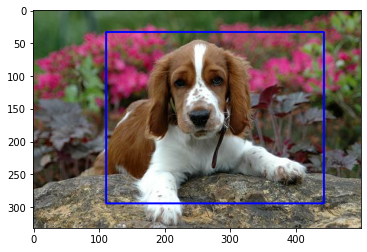

In [31]:
image = copy.deepcopy(item['image'])
image = cv2.drawContours(image, [rect], 0, (0,0,255), 2)
plt.imshow(image)
plt.show()

### Intersection Over Union
- CAM과 Grad-CAM 두 가지 방법을 통해서 바운딩 박스를 얻을 수 있었습니다. 그럼 정답 데이터인 바운딩 박스와 이를 어떻게 비교, 평가할 수 있을까?  


- **IoU(Intersection over Union)** 는 두 영역의 교집합인 **intersection** 영역의 넓이를 두 영역의 합집합인 **union** 영역으로 나누어준 값이다
- 이를 통해 찾고자 하는 물건의 절대적인 면적과 상관없이, 영역을 정확하게 잘 찾아내었는지의 상대적인 비율을 구할 수 있으므로, 모델이 영역을 잘 찾았는지 비교하는 좋은 지표가 된다

In [32]:
# rect의 좌표는 (x, y) 형태로, bbox는 (y_min, x_min, y_max, x_max)의 normalized 형태로 주어집니다. 
def rect_to_minmax(rect, image):
    bbox = [
        rect[:,1].min()/float(image.shape[0]),  #bounding box의 y_min
        rect[:,0].min()/float(image.shape[1]),  #bounding box의 x_min
        rect[:,1].max()/float(image.shape[0]), #bounding box의 y_max
        rect[:,0].max()/float(image.shape[1]) #bounding box의 x_max
    ]
    return bbox

print('완료')

완료


In [33]:
pred_bbox = rect_to_minmax(rect, item['image'])
pred_bbox

[0.09939759036144578, 0.222, 0.8855421686746988, 0.886]

In [34]:
item['objects']['bbox']

array([[0.13554217, 0.146     , 0.9879518 , 0.826     ]], dtype=float32)

In [35]:
def get_iou(boxA, boxB):
    y_min = max(boxA[0], boxB[0])
    x_min= max(boxA[1], boxB[1])
    y_max = min(boxA[2], boxB[2])
    x_max = min(boxA[3], boxB[3])
    
    interArea = max(0, x_max - x_min) * max(0, y_max - y_min)
    boxAArea = (boxA[2] - boxA[0]) * (boxA[3] - boxA[1])
    boxBArea = (boxB[2] - boxB[0]) * (boxB[3] - boxB[1])
    iou = interArea / float(boxAArea + boxBArea - interArea)

    return iou

print('완료')

완료


In [36]:
get_iou(pred_bbox, item['objects']['bbox'][0])

0.6983858334151163